# Deep Learning for California Housing Pricing Regression

Name: Anirudh Sharma

Date: 5 October 2025

Roll No: MT2025732

### Problem Statement

* On a real regression dataset (choose your own), show the performance of linear vs polynomial regression for different choices of M on the validation dataset (split the data into train, validation and test). Use L2 and L1 regularisation and comment on the results. Report test results with and without regularisation. Use closed form to obtain model parameters
* Next, use gradient descent - both full-batch, mini-batch, SGD and compare the convergence speeds.

# Part 0: Project Setup

### Constraints:
* Perform regression and compare performance
* Polynomial Features = `[1 or None, 2, 3, 4]`
* Regularization = `[None, L1, L2]`
* Training strategy = `[Closed Form, Gradient Descent]`

### Aim: To demonstrate the effect of the above hyperparameter selection on validation data

### Discovery:
* Dataset chosen: `California Housing Dataset`
* Dataset link: `https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html`

In [30]:
import chime
import random, time, json, os
import functools, itertools

import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib as mpl  # Matplot globals
import seaborn as sns

from pprint import pprint

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as tutils
import torch.utils.benchmark as tben
import torch.nn.functional as F
import torch.profiler as profiler

chime.theme("material")
chime.info()

In [2]:
default_seed = 1114  # 1114 stands for Minecraftian14, which is me, ofc


def set_seed(seed=default_seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


chime.info()

In [3]:
mpl.rcParams['font.family'] = 'monospace'
font_title = {'fontsize': 18, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}
chime.info()

# Part 1: Data Loading and Exploratory Data Analysis (EDA)

In [4]:
%time
housing = skl.datasets.fetch_california_housing()

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
housing = skl.datasets.fetch_california_housing()

ds_x, ds_y = housing.data, housing.target  # get the data
feature_names = housing.feature_names
target_name = housing.target_names[0]

ds_y = ds_y.reshape((-1, 1)) - 1  # 0-index
n_samples = ds_x.shape[0]
n_features = ds_x.shape[1]

print(f"Number of samples : {n_samples}")
print(f"Number of features: {n_features}")
print()
print(f"""Feature names:
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'""")

df = pd.DataFrame(ds_x, columns=feature_names)
df[target_name] = ds_y
display(df.head())
display(df.describe())
chime.info()

Number of samples : 20640
Number of features: 8

Feature names:
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,3.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,2.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,2.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,1.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,-0.850010
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,0.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,0.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,1.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,4.000010


In [6]:
# Check for any null values in the entire dataframe
missing_values = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {missing_values}")

Total missing values in the dataset: 0


In [7]:
del df

# Part 2: Data Preprocessing and Preparation

In [8]:
ds_x_1 = skl.preprocessing.PolynomialFeatures(degree=1).fit_transform(ds_x)
ds_x_2 = skl.preprocessing.PolynomialFeatures(degree=2).fit_transform(ds_x)
ds_x_3 = skl.preprocessing.PolynomialFeatures(degree=3).fit_transform(ds_x)
ds_x_4 = skl.preprocessing.PolynomialFeatures(degree=4).fit_transform(ds_x)

In [15]:
degree_to_data = {1: ds_x_1, 2: ds_x_2, 3: ds_x_3, 4: ds_x_4}

In [16]:
for d in degree_to_data.keys():
    _ds_x = degree_to_data[d]
    x_train, x_temp, y_train, y_temp = (skl.model_selection.train_test_split
                                        (_ds_x, ds_y, test_size=0.3, random_state=default_seed))
    x_val, x_test, y_val, y_test = (skl.model_selection.train_test_split
                                    (x_temp, y_temp, test_size=0.5, random_state=default_seed))
    degree_to_data[d] = (x_train, y_train, x_val, y_val, x_test, y_test)
    del _ds_x

print("Training Set Size  :", x_train.shape[0])
print("Validation Set Size:", x_val.shape[0])
print("Test Set Size      :", x_test.shape[0])

Training Set Size  : 14448
Validation Set Size: 3096
Test Set Size      : 3096


In [85]:
degree_to_data[4][0].shape[1]

495

In [103]:
x = np.asarray([[1, 2, 3], [2, 4, 6], [1, 2, 3], [1, 2, 3]])
(np.linalg.pinv(x.T @ x)@((x.T @ x).T)).sum()

np.float64(2.5714285714285716)

In [100]:
x = np.random.randn(3, 3)
np.linalg.pinv(x.T @ x) @ (x.T @ x)

array([[ 1.00000000e+00, -4.44089210e-16,  0.00000000e+00],
       [-8.88178420e-16,  1.00000000e+00,  1.11022302e-16],
       [-4.44089210e-16, -1.77635684e-15,  1.00000000e+00]])

In [17]:
for d in degree_to_data.keys():
    scaler = skl.preprocessing.StandardScaler()
    x_train, y_train, x_val, y_val, x_test, y_test = degree_to_data[d]
    x_train_sc = scaler.fit_transform(x_train)
    x_val_sc = scaler.transform(x_val)
    x_test_sc = scaler.transform(x_test)
    degree_to_data[d] = (x_train_sc, y_train, x_val_sc, y_val, x_test_sc, y_test)
    del x_train, x_val, x_test

In [18]:
def prepare_data(batch_size, degree, device):
    device = torch.device(device)

    x_train, y_train, x_val, y_val, x_test, y_test = degree_to_data[degree]

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32, device=device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

    train_dataset = tutils.data.TensorDataset(x_train_tensor, y_train_tensor)

    val_dataset = tutils.data.TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = tutils.data.TensorDataset(x_test_tensor, y_test_tensor)

    if batch_size is None:
        batch_size = len(train_dataset)

    train_loader = tutils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = tutils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = tutils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_loader, val_loader, test_loader

# Part 3: Model Architecture Definitions

In [19]:
def create_model(n_features, device):
    device = torch.device(device)
    model = nn.Linear(n_features, 1, device=device, bias=False)
    nn.init.xavier_uniform_(model.weight)
    return model

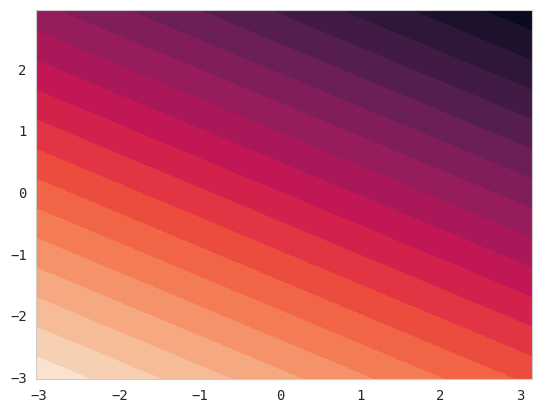

In [20]:
set_seed()

dummy_model = create_model(n_features=2, device='cpu')
dummy_x = torch.randn(1024, 2)
x1_grid, x2_grid = np.meshgrid(
    np.linspace(dummy_x[:, 0].min(), dummy_x[:, 0].max(), 100),
    np.linspace(dummy_x[:, 1].min(), dummy_x[:, 1].max(), 100)
)
grid_points = np.c_[x1_grid.ravel(), x2_grid.ravel()]
dummy_y = dummy_model(torch.asarray(grid_points)).detach().numpy()[:, 0].reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, dummy_y, levels=20)
plt.show()
chime.info()

# Part 4: Generic Training and Evaluation Functions

In [21]:
def set_learning_rate(optimizer, learning_rate):
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate


def train_step_cf(model, train_loader, val_loader, loss_fn, regularization, reg_lambda):
    start_time = tben.timer()
    train_loss, train_r2 = [], []
    val_loss, val_r2 = [], []

    with torch.no_grad():
        model: nn.Linear  # y = x w^T + b = X theta^T

        # In this experiment I do not have batches, so most probably the data loader only has one sample
        x_batch, y_batch = next(iter(train_loader))
        x_batch_t, y_batch_t = next(iter(val_loader))

        p_batch = model(x_batch)
        train_loss.append(loss_fn(p_batch, y_batch).item())
        train_r2.append(skl.metrics.r2_score(y_batch, p_batch))
        p_batch_t = model(x_batch_t)
        val_loss.append(loss_fn(p_batch_t, y_batch_t).item())
        val_r2.append(skl.metrics.r2_score(y_batch_t, p_batch_t))

        # weights are [fan_out=1, fan_in]
        if regularization == None:
            model.weight.data = (torch.pinverse((x_batch.T @ x_batch)) @ (x_batch.T @ y_batch)).T
        elif regularization == 2:
            norm = reg_lambda * torch.eye(x_batch.shape[1], dtype=x_batch.dtype)
            norm[0, 0] = 0  # Don't bother bias
            model.weight.data = (torch.pinverse((x_batch.T @ x_batch) + norm) @ (x_batch.T @ y_batch)).T
        elif regularization == 1:
            lasso = skl.linear_model.Lasso(alpha=reg_lambda, fit_intercept=False, max_iter=100)
            lasso.fit(x_batch, y_batch)
            model.weight.data = torch.asarray(lasso.coef_, dtype=torch.float32).reshape((1, -1))
        else:
            raise NotImplementedError

        p_batch = model(x_batch)
        train_loss.append(loss_fn(p_batch, y_batch).item())
        train_r2.append(skl.metrics.r2_score(y_batch, p_batch))
        p_batch_t = model(x_batch_t)
        val_loss.append(loss_fn(p_batch_t, y_batch_t).item())
        val_r2.append(skl.metrics.r2_score(y_batch_t, p_batch_t))

    return {'train_loss': train_loss, 'train_r2': train_r2, 'val_loss': val_loss, 'val_r2': val_r2,
            'total_time': tben.timer() - start_time}


def train_step_gd(epoch, epochs, model, train_loader, val_loader, loss_fn, optimizer, regularization, limit, reg_lambda,
                  learning_rate):
    start_time = tben.timer()

    model.train()
    train_loss, train_r2 = [], []
    val_loss, val_r2 = [], []

    skip_batches = 1
    no_of_batches = len(train_loader)
    if no_of_batches > 100:
        skip_batches = no_of_batches // 100

    train_p_buffer, train_y_buffer, val_p_buffer, val_y_buffer = [], [], [], []

    with tqdm(total=no_of_batches) as pbar:
        for batch, (x_batch, y_batch) in enumerate(train_loader):
            if limit is not None and batch >= limit:
                break

            set_learning_rate(optimizer, learning_rate)

            p_batch = model(x_batch)  # Predictions
            loss = loss_fn(p_batch, y_batch)
            train_loss.append(loss.item())
            if regularization is not None:
                norm = torch.zeros(())
                iaur = 0
                for p in model.parameters():
                    norm += p.abs().pow(regularization).mean()
                    iaur += 1
                loss += reg_lambda * norm.pow(1 / regularization) / iaur

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if len(y_batch) > 1:
                train_r2.append(skl.metrics.r2_score(y_batch, p_batch.detach().numpy()))
                pbar.desc = f"Epoch %3d/%d [Train] Loss: %9.6f Accuracy: %7.6f" % (epoch, epochs, train_loss[-1],
                                                                                   train_r2[-1])
            else:
                train_y_buffer.append(y_batch.squeeze()), train_p_buffer.append(p_batch.detach().numpy().squeeze())
                if len(train_p_buffer) >= 8:
                    train_r2.append(skl.metrics.r2_score(train_y_buffer, train_p_buffer))
                    train_y_buffer.clear(), train_p_buffer.clear()
                    pbar.desc = f"Epoch %3d/%d [Train] Loss: %9.6f Accuracy: %7.6f" % (epoch, epochs, train_loss[-1],
                                                                                       train_r2[-1])
            pbar.update(1)

            if batch == 0 or (batch - 1) % skip_batches == 0:
                model.eval()

                with torch.no_grad():
                    x_batch, y_batch = next(iter(val_loader))
                    p_batch = model(x_batch)
                    loss = loss_fn(p_batch, y_batch)
                    val_loss.append(loss.item())

                    if len(y_batch) > 1:
                        val_r2.append(skl.metrics.r2_score(y_batch, p_batch))
                    else:
                        val_y_buffer.append(y_batch.squeeze()), val_p_buffer.append(p_batch.squeeze())
                        if len(val_p_buffer) >= 8:
                            val_r2.append(skl.metrics.r2_score(val_y_buffer, val_p_buffer))
                            val_y_buffer.clear(), val_p_buffer.clear()

                model.train()

    return {'train_loss': train_loss, 'train_r2': train_r2, 'val_loss': val_loss, 'val_r2': val_r2,
            'total_time': tben.timer() - start_time}


def train_step(epoch, epochs, model, train_loader, val_loader, loss_fn, optimizer, regularization, limit, reg_lambda,
               learning_rate):
    if optimizer == 'Closed Form':
        return train_step_cf(model, train_loader, val_loader, loss_fn, regularization, reg_lambda)
    else:
        return train_step_gd(epoch, epochs, model, train_loader, val_loader, loss_fn, optimizer, regularization, limit,
                             reg_lambda, learning_rate)


def parse_elements(training_strategy, optimization_strategy, regularization, learning_rate, _model):
    _batch_size = None
    _optimizer = None
    _regularization = None

    if training_strategy == 'Stochastic':
        _batch_size = 1
    elif training_strategy.startswith('Mini Batch '):
        _batch_size = int(training_strategy[len('Mini Batch '):])
    elif training_strategy == 'Batch':
        _batch_size = None

    if optimization_strategy == 'Normal':
        _optimizer = optim.SGD(params=_model.parameters(), lr=learning_rate)
    elif optimization_strategy == 'Momentum':
        _optimizer = optim.SGD(params=_model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimization_strategy == 'RMSProp':
        _optimizer = optim.RMSprop(params=_model.parameters(), lr=learning_rate)
    elif optimization_strategy == 'Adam':
        _optimizer = optim.Adam(params=_model.parameters(), lr=learning_rate)
    else:
        _optimizer = optimization_strategy  # Possibly Closed Form

    if regularization is not None:
        _regularization = int(regularization[len('L'):])

    return _batch_size, _optimizer, _regularization

In [22]:
# set_seed()
#
# loss_fn = nn.MSELoss()
# train_loader, val_loader, _ = prepare_data(None, 2, 'cpu')
# model = create_model(train_loader.dataset.tensors[0].shape[1], 'cpu')
#
# train_step_cf(model, train_loader, val_loader, loss_fn, None, 1.0)

In [23]:
def run_experiment(training_strategy, optimization_strategy,
                   regularization, learning_rate, device,
                   epochs, limit, reg_lambda, degree):
    if training_strategy == 'Stochastic':
        _batch_size = 1
    elif training_strategy.startswith('Mini Batch '):
        _batch_size = int(training_strategy[len('Mini Batch '):])
    elif training_strategy == 'Batch':
        _batch_size = None

    train_loader, val_loader, test_loader = prepare_data(_batch_size, degree, device)
    model = create_model(train_loader.dataset.tensors[0].shape[1], device)
    batch_size, optimizer, regularization = parse_elements(
        training_strategy, optimization_strategy, regularization, learning_rate, model)

    train_loss, train_r2, val_loss, val_r2 = [], [], [], []
    total_time = 0

    for epoch in range(epochs):
        history = train_step(epoch, epochs, model, train_loader, val_loader, loss_fn, optimizer, regularization, limit,
                             reg_lambda, learning_rate)
        train_loss.extend(history['train_loss'])
        train_r2.extend(history['train_r2'])
        val_loss.extend(history['val_loss'])
        val_r2.extend(history['val_r2'])
        total_time += history['total_time']

    return {
        'parameters': {'Data Loader': training_strategy, 'Optimizer': optimization_strategy,
                       'Regularization': regularization, 'Learning Rate': learning_rate, 'Device': device,
                       'Epochs': epochs, 'Limit': limit},
        'model': model,
        'train_loss': train_loss, 'train_r2': train_r2, 'val_loss': val_loss, 'val_r2': val_r2,
        'total_time': total_time
    }

In [24]:
def plot(ax: plt.Axes, data, title, density=150):
    if len(data) > density:
        data = data[::(len(data) // density)]
    ax.plot(data)
    ax.set_title(title)
    # if 'R2 Score' in title:
    #     ax.set_ylim(0, 1)


def prepare_report(history):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    plot(axs[0][0], history['train_loss'], "Train Loss")
    plot(axs[0][1], history['val_loss'], "Validation Loss")
    plot(axs[1][0], history['train_r2'], "Train R2 Score")
    plot(axs[1][1], history['val_r2'], "Validation R2 Score")

    params = history['parameters']
    params['Total Time'] = "%4.2f sec" % history['total_time']
    key_length = max([len(k) for k in params.keys()]) + 1
    val_length = max([len(str(v)) for v in params.values()])
    metadata = "\n".join([f"%-{key_length}s: %-{val_length}s" % (k, v) for k, v in params.items()])
    fig.suptitle("Training Report", x=0.05, y=1, ha='left', **font_title)
    fig.text(0.95, 1, metadata, ha="right", va="top", **font_label)

    fig.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()


In [25]:
def save_history(title, history: dict):
    model = history['model']
    history = {k: v for k, v in history.items() if k != 'model'}
    with open(f"saves/history_r_{title}.json", "w") as f:
        json.dump(history, f, indent=2)
    torch.save(model.state_dict(), f"saves/model_r_{title}.pth")


def load_history(title, include_model=True):
    with open(f"saves/history_r_{title}.json", "r") as f:
        history = json.load(f)
    parameters = history['parameters']
    if include_model:
        model = parse_elements(training_strategy=parameters['Data Loader'],
                               optimization_strategy=parameters['Optimizer'],
                               regularization=parameters['Regularization'],
                               learning_rate=parameters['Learning Rate'],
                               device=parameters['Device']
                               )[3]
        model.load_state_dict(torch.load(f"saves/model_r_{title}.pth"))
        history['model'] = model
    return history

Epoch   0/1 [Train] Loss:  1.587498 Accuracy: -0.104574: 100%|██████████| 903/903 [00:04<00:00, 202.93it/s]


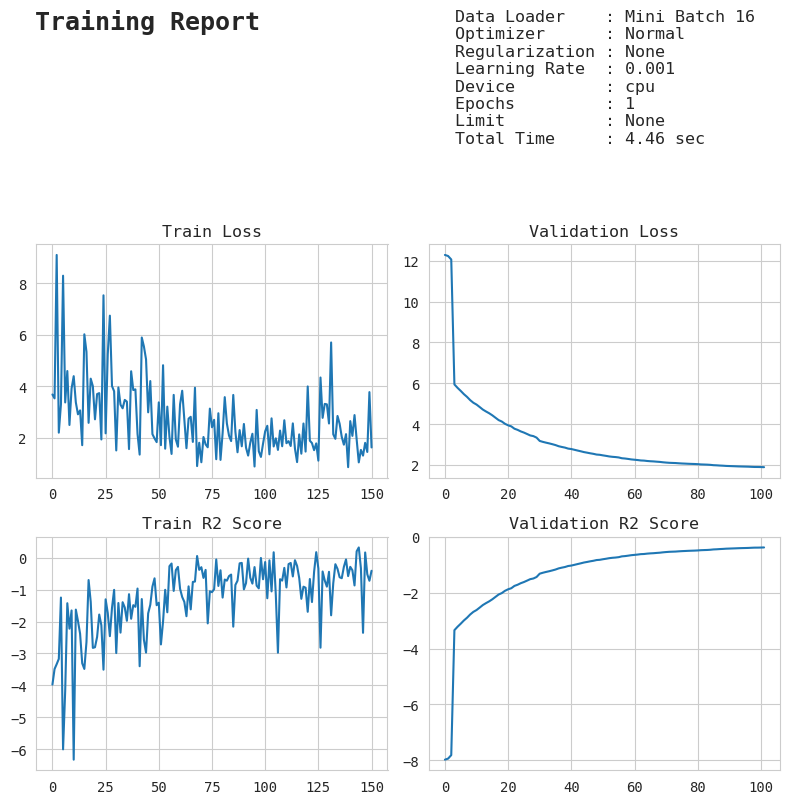

In [26]:
loss_fn = nn.MSELoss()

history = run_experiment(training_strategy='Mini Batch 16', optimization_strategy='Normal', regularization=None,
                         learning_rate=0.001,
                         device='cpu', epochs=1, limit=None, reg_lambda=0.1, degree=1)

prepare_report(history)
chime.info()

Epoch   0/4 [Train] Loss:  0.793855 Accuracy: 0.274343: 100%|██████████| 29/29 [00:01<00:00, 17.44it/s] 
Epoch   1/4 [Train] Loss:  1.070863 Accuracy: 0.391835: 100%|██████████| 29/29 [00:01<00:00, 17.16it/s]
Epoch   2/4 [Train] Loss:  0.511913 Accuracy: 0.528773: 100%|██████████| 29/29 [00:01<00:00, 16.61it/s]
Epoch   3/4 [Train] Loss:  0.515456 Accuracy: 0.533687: 100%|██████████| 29/29 [00:01<00:00, 19.28it/s]


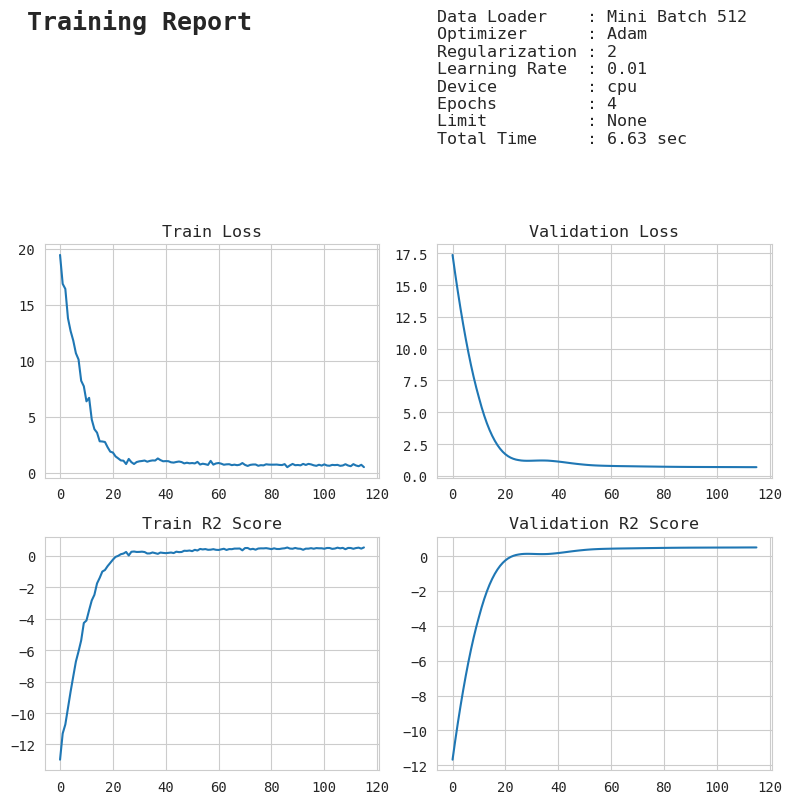

In [43]:
loss_fn = nn.MSELoss()

history = run_experiment(training_strategy='Mini Batch 512', optimization_strategy='Adam', regularization='L2',
                         learning_rate=0.01,
                         device='cpu', epochs=4, limit=None, reg_lambda=5, degree=1)

prepare_report(history)
chime.info()

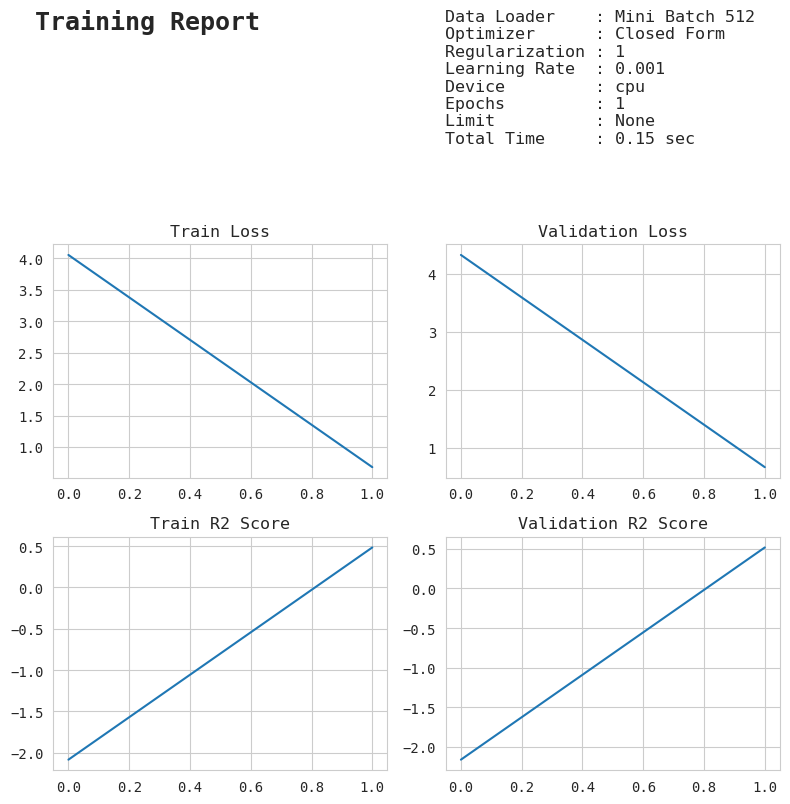

In [44]:
loss_fn = nn.MSELoss()

history = run_experiment(training_strategy='Mini Batch 512', optimization_strategy='Closed Form', regularization='L1',
                         learning_rate=0.001,
                         device='cpu', epochs=1, limit=None, reg_lambda=0.1, degree=1)

prepare_report(history)
chime.info()

# Part 5: Experimentation and Hyperparameter Tuning (on Validation Set)

In [43]:
# Kind of a grid search
perm_degree = [1, 2, 3]
perm_data_loaders = ['Stochastic', 'Mini Batch 512', 'Batch']
perm_optimizations = ['Closed Form', 'Adam']
perm_regularization = [None, 'L1', 'L2']

perm_history = {}

In [44]:
if input(
        "Warning! This is a time consuming Grid Search! Last run took 4 hours to complete. Do you want to run it?") == "YES":
    for degree, data_loaders, optimizations, regularization \
            in itertools.product(perm_degree, perm_data_loaders, perm_optimizations, perm_regularization):
        key = ", ".join([str(degree), data_loaders, optimizations, str(regularization)])
        epoch = 3
        reg_lambda = 1
        if optimizations == 'Closed Form':
            epoch = 1
            if data_loaders in ('Stochastic', 'Mini Batch 512'):
                continue
            if regularization == 'L1':
                reg_lambda = 0.1
            elif regularization == 'L2':
                reg_lambda = 30
        print(key)
        history = run_experiment(training_strategy=data_loaders, optimization_strategy=optimizations,
                                 regularization=regularization,
                                 learning_rate=0.001,
                                 device='cpu', epochs=epoch, limit=None, reg_lambda=reg_lambda, degree=degree)
        perm_history[key] = history
        save_history(key, history)
        chime.info()

    chime.success()

1, Stochastic, Adam, None


Epoch   0/3 [Train] Loss:  0.006784 Accuracy: 0.379788: 100%|██████████| 14448/14448 [00:14<00:00, 1007.31it/s] 
Epoch   1/3 [Train] Loss:  1.751034 Accuracy: -0.606513: 100%|██████████| 14448/14448 [00:13<00:00, 1054.60it/s]
Epoch   2/3 [Train] Loss:  1.834713 Accuracy: -0.045488: 100%|██████████| 14448/14448 [00:13<00:00, 1043.42it/s]   


1, Stochastic, Adam, L1


Epoch   0/3 [Train] Loss:  0.189410 Accuracy: -1.537676: 100%|██████████| 14448/14448 [00:18<00:00, 778.81it/s]
Epoch   1/3 [Train] Loss:  2.307350 Accuracy: -0.370392: 100%|██████████| 14448/14448 [00:16<00:00, 861.95it/s]
Epoch   2/3 [Train] Loss:  4.757246 Accuracy: -0.527305: 100%|██████████| 14448/14448 [00:17<00:00, 846.32it/s]


1, Stochastic, Adam, L2


Epoch   0/3 [Train] Loss:  0.110844 Accuracy: 0.040133: 100%|██████████| 14448/14448 [00:19<00:00, 758.50it/s] 
Epoch   1/3 [Train] Loss:  0.018558 Accuracy: 0.102893: 100%|██████████| 14448/14448 [00:19<00:00, 751.44it/s] 
Epoch   2/3 [Train] Loss:  3.354045 Accuracy: -0.053777: 100%|██████████| 14448/14448 [00:17<00:00, 822.62it/s]


1, Mini Batch 512, Adam, None


Epoch   0/3 [Train] Loss:  4.318366 Accuracy: -2.734687: 100%|██████████| 29/29 [00:01<00:00, 18.20it/s]
Epoch   1/3 [Train] Loss:  3.243635 Accuracy: -1.697961: 100%|██████████| 29/29 [00:01<00:00, 22.38it/s]
Epoch   2/3 [Train] Loss:  3.033172 Accuracy: -1.422605: 100%|██████████| 29/29 [00:01<00:00, 24.64it/s]


1, Mini Batch 512, Adam, L1


Epoch   0/3 [Train] Loss:  4.279575 Accuracy: -2.981301: 100%|██████████| 29/29 [00:01<00:00, 20.30it/s]
Epoch   1/3 [Train] Loss:  4.886418 Accuracy: -2.556355: 100%|██████████| 29/29 [00:01<00:00, 22.32it/s]
Epoch   2/3 [Train] Loss:  4.629977 Accuracy: -2.084900: 100%|██████████| 29/29 [00:01<00:00, 24.20it/s]


1, Mini Batch 512, Adam, L2


Epoch   0/3 [Train] Loss:  2.061506 Accuracy: -0.749711: 100%|██████████| 29/29 [00:01<00:00, 18.79it/s]
Epoch   1/3 [Train] Loss:  2.607481 Accuracy: -0.936455: 100%|██████████| 29/29 [00:01<00:00, 18.00it/s]
Epoch   2/3 [Train] Loss:  2.255130 Accuracy: -0.669106: 100%|██████████| 29/29 [00:01<00:00, 25.28it/s]


1, Batch, Closed Form, None
1, Batch, Closed Form, L1
1, Batch, Closed Form, L2
1, Batch, Adam, None


Epoch   0/3 [Train] Loss:  6.753911 Accuracy: -4.093093: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]
Epoch   1/3 [Train] Loss:  6.741504 Accuracy: -4.083737: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]
Epoch   2/3 [Train] Loss:  6.729120 Accuracy: -4.074399: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


1, Batch, Adam, L1


Epoch   0/3 [Train] Loss:  3.658143 Accuracy: -1.758589: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
Epoch   1/3 [Train] Loss:  3.649836 Accuracy: -1.752325: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
Epoch   2/3 [Train] Loss:  3.641552 Accuracy: -1.746078: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


1, Batch, Adam, L2


Epoch   0/3 [Train] Loss:  2.800113 Accuracy: -1.111552: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
Epoch   1/3 [Train] Loss:  2.793767 Accuracy: -1.106767: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
Epoch   2/3 [Train] Loss:  2.787448 Accuracy: -1.102002: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


2, Stochastic, Adam, None


Epoch   0/3 [Train] Loss:  3.042307 Accuracy: 0.193368: 100%|██████████| 14448/14448 [00:15<00:00, 959.17it/s]  
Epoch   1/3 [Train] Loss:  6.147436 Accuracy: -0.212757: 100%|██████████| 14448/14448 [00:14<00:00, 974.13it/s] 
Epoch   2/3 [Train] Loss:  0.000549 Accuracy: -0.809699: 100%|██████████| 14448/14448 [00:14<00:00, 1031.19it/s]


2, Stochastic, Adam, L1


Epoch   0/3 [Train] Loss:  0.002506 Accuracy: -0.469092: 100%|██████████| 14448/14448 [00:16<00:00, 850.95it/s]
Epoch   1/3 [Train] Loss:  2.137153 Accuracy: -1.159920: 100%|██████████| 14448/14448 [00:16<00:00, 854.78it/s]
Epoch   2/3 [Train] Loss:  0.452906 Accuracy: -0.034188: 100%|██████████| 14448/14448 [00:16<00:00, 876.21it/s] 


2, Stochastic, Adam, L2


Epoch   0/3 [Train] Loss:  5.274479 Accuracy: -0.597709: 100%|██████████| 14448/14448 [00:16<00:00, 859.71it/s]  
Epoch   1/3 [Train] Loss:  4.231700 Accuracy: -1.010510: 100%|██████████| 14448/14448 [00:16<00:00, 862.34it/s]
Epoch   2/3 [Train] Loss:  0.798581 Accuracy: -0.110499: 100%|██████████| 14448/14448 [00:16<00:00, 878.70it/s]


2, Mini Batch 512, Adam, None


Epoch   0/3 [Train] Loss:  2.331699 Accuracy: -1.014146: 100%|██████████| 29/29 [00:01<00:00, 22.90it/s]
Epoch   1/3 [Train] Loss:  2.159368 Accuracy: -1.044209: 100%|██████████| 29/29 [00:01<00:00, 20.32it/s]
Epoch   2/3 [Train] Loss:  2.442772 Accuracy: -0.551598: 100%|██████████| 29/29 [00:01<00:00, 26.00it/s]


2, Mini Batch 512, Adam, L1


Epoch   0/3 [Train] Loss:  3.165311 Accuracy: -1.760525: 100%|██████████| 29/29 [00:01<00:00, 23.15it/s]
Epoch   1/3 [Train] Loss:  2.997137 Accuracy: -1.192120: 100%|██████████| 29/29 [00:01<00:00, 23.90it/s]
Epoch   2/3 [Train] Loss:  2.949417 Accuracy: -1.212521: 100%|██████████| 29/29 [00:01<00:00, 25.22it/s]


2, Mini Batch 512, Adam, L2


Epoch   0/3 [Train] Loss:  1.619256 Accuracy: -0.127166: 100%|██████████| 29/29 [00:01<00:00, 22.92it/s]
Epoch   1/3 [Train] Loss:  1.624174 Accuracy: -0.233680: 100%|██████████| 29/29 [00:01<00:00, 24.68it/s]
Epoch   2/3 [Train] Loss:  1.652106 Accuracy: -0.232390: 100%|██████████| 29/29 [00:01<00:00, 25.67it/s]


2, Batch, Closed Form, None
2, Batch, Closed Form, L1


C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+01, tolerance: 3.584e+00
  model = cd_fast.enet_coordinate_descent(


2, Batch, Closed Form, L2
2, Batch, Adam, None


Epoch   0/3 [Train] Loss:  3.050027 Accuracy: -1.300012: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
Epoch   1/3 [Train] Loss:  3.016718 Accuracy: -1.274894: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
Epoch   2/3 [Train] Loss:  2.984020 Accuracy: -1.250236: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


2, Batch, Adam, L1


Epoch   0/3 [Train] Loss:  5.620160 Accuracy: -3.238137: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
Epoch   1/3 [Train] Loss:  5.565808 Accuracy: -3.197150: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]
Epoch   2/3 [Train] Loss:  5.512187 Accuracy: -3.156716: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


2, Batch, Adam, L2


Epoch   0/3 [Train] Loss:  3.586227 Accuracy: -1.704358: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
Epoch   1/3 [Train] Loss:  3.545705 Accuracy: -1.673800: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
Epoch   2/3 [Train] Loss:  3.505790 Accuracy: -1.643701: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


3, Stochastic, Adam, None


Epoch   0/3 [Train] Loss:  0.004547 Accuracy: -1.566064: 100%|██████████| 14448/14448 [00:13<00:00, 1079.28it/s]
Epoch   1/3 [Train] Loss:  3.724508 Accuracy: -0.374736: 100%|██████████| 14448/14448 [00:13<00:00, 1051.34it/s] 
Epoch   2/3 [Train] Loss:  4.420019 Accuracy: -0.229210: 100%|██████████| 14448/14448 [00:13<00:00, 1044.59it/s] 


3, Stochastic, Adam, L1


Epoch   0/3 [Train] Loss:  0.409088 Accuracy: 0.339359: 100%|██████████| 14448/14448 [00:17<00:00, 811.60it/s] 
Epoch   1/3 [Train] Loss:  1.233418 Accuracy: -1.584882: 100%|██████████| 14448/14448 [00:17<00:00, 814.84it/s]
Epoch   2/3 [Train] Loss:  1.076011 Accuracy: -0.468764: 100%|██████████| 14448/14448 [00:18<00:00, 780.11it/s]  


3, Stochastic, Adam, L2


Epoch   0/3 [Train] Loss:  1.517534 Accuracy: -4.174916: 100%|██████████| 14448/14448 [00:19<00:00, 755.74it/s]    
Epoch   1/3 [Train] Loss:  0.037931 Accuracy: -1.185905: 100%|██████████| 14448/14448 [00:19<00:00, 728.88it/s]  
Epoch   2/3 [Train] Loss:  0.219000 Accuracy: -1.189532: 100%|██████████| 14448/14448 [00:19<00:00, 744.73it/s]  


3, Mini Batch 512, Adam, None


Epoch   0/3 [Train] Loss:  1.948863 Accuracy: -0.451501: 100%|██████████| 29/29 [00:01<00:00, 19.80it/s]
Epoch   1/3 [Train] Loss:  1.590995 Accuracy: -0.569556: 100%|██████████| 29/29 [00:01<00:00, 19.89it/s]
Epoch   2/3 [Train] Loss:  1.504007 Accuracy: -0.465032: 100%|██████████| 29/29 [00:01<00:00, 20.36it/s]


3, Mini Batch 512, Adam, L1


Epoch   0/3 [Train] Loss:  2.158307 Accuracy: -0.495242: 100%|██████████| 29/29 [00:01<00:00, 20.49it/s]
Epoch   1/3 [Train] Loss:  1.448398 Accuracy: -0.435116: 100%|██████████| 29/29 [00:01<00:00, 19.64it/s]
Epoch   2/3 [Train] Loss:  1.894755 Accuracy: -0.364383: 100%|██████████| 29/29 [00:01<00:00, 19.69it/s]


3, Mini Batch 512, Adam, L2


Epoch   0/3 [Train] Loss:  2.659954 Accuracy: -1.035312: 100%|██████████| 29/29 [00:01<00:00, 19.84it/s]
Epoch   1/3 [Train] Loss:  1.997096 Accuracy: -0.626214: 100%|██████████| 29/29 [00:01<00:00, 18.44it/s]
Epoch   2/3 [Train] Loss:  2.214384 Accuracy: -0.564317: 100%|██████████| 29/29 [00:01<00:00, 21.96it/s]


3, Batch, Closed Form, None
3, Batch, Closed Form, L1


C:\Users\mcxiv\.conda\envs\pyt\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e+01, tolerance: 3.584e+00
  model = cd_fast.enet_coordinate_descent(


3, Batch, Closed Form, L2
3, Batch, Adam, None


Epoch   0/3 [Train] Loss:  5.550412 Accuracy: -3.185541: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
Epoch   1/3 [Train] Loss:  5.341165 Accuracy: -3.027748: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
Epoch   2/3 [Train] Loss:  5.140954 Accuracy: -2.876770: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


3, Batch, Adam, L1


Epoch   0/3 [Train] Loss:  6.320183 Accuracy: -3.766022: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Epoch   1/3 [Train] Loss:  6.099393 Accuracy: -3.599524: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
Epoch   2/3 [Train] Loss:  5.888116 Accuracy: -3.440202: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


3, Batch, Adam, L2


Epoch   0/3 [Train] Loss:  4.566894 Accuracy: -2.443873: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
Epoch   1/3 [Train] Loss:  4.387989 Accuracy: -2.308963: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Epoch   2/3 [Train] Loss:  4.216334 Accuracy: -2.179519: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


In [33]:
# Load all history

def load_all_history(include_model=False):
    for hidden_layers, activations, data_loaders, optimizations, regularization \
            in itertools.product(perm_degree, perm_data_loaders, perm_optimizations, perm_regularization):
        key = ", ".join([str(degree), data_loaders, optimizations, str(regularization)])
        if not os.path.exists(f"saves/history_r_{key}.json"): continue
        perm_history[key] = load_history(key, include_model)

In [45]:
len(perm_history.keys())

36

In [19]:
load_all_history()
chime.info()

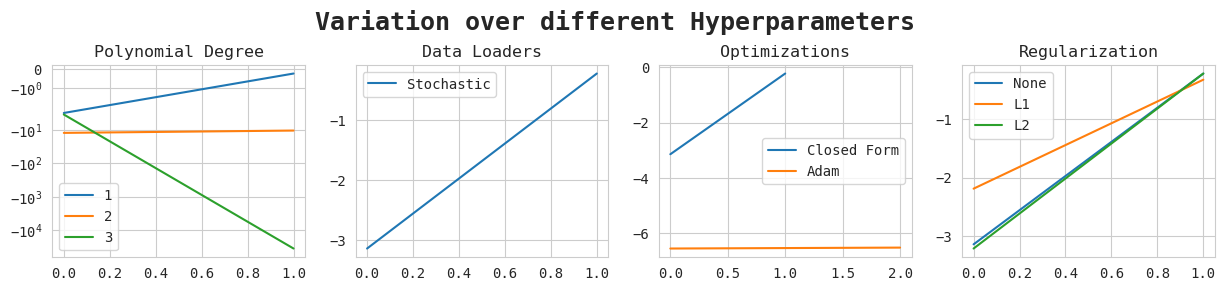

In [54]:
base_hyperparameter_selection = {
    'degree': [1],
    'data_loaders': ['Batch'],
    'optimizations': ['Closed Form'],
    'regularization': [None],
}


def plot_hyperparameter_variation(title, name, values, ax):
    selection = base_hyperparameter_selection.copy()
    selection[name] = values
    ax.set_title(title)

    index = 0
    for degree, data_loaders, optimizations, regularization \
            in itertools.product(selection['degree'], selection['data_loaders'],
                                 selection['optimizations'], selection['regularization']):
        key = ", ".join([str(degree), data_loaders, optimizations, str(regularization)])
        if key not in perm_history: continue
        ax.plot(perm_history[key]["val_r2"], label=str(values[index]))
        index += 1

    ax.legend()

fig, axs = plt.subplots(1, 4, figsize=(15, 2.5))
plot_hyperparameter_variation("Polynomial Degree", "degree", perm_degree, axs[0])
axs[0].set_yscale('symlog')
plot_hyperparameter_variation("Data Loaders", "data_loaders", perm_data_loaders, axs[1])
plot_hyperparameter_variation("Optimizations", "optimizations", perm_optimizations, axs[2])
plot_hyperparameter_variation("Regularization", "regularization", perm_regularization, axs[3])
plt.suptitle('Variation over different Hyperparameters', **font_title, x=0.5, y=1.1)
plt.show()

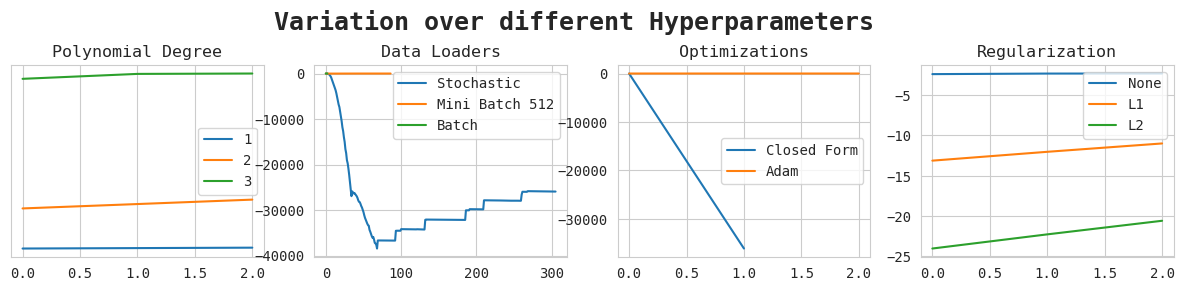

In [60]:
base_hyperparameter_selection = {
    'degree': [3],
    'data_loaders': ['Batch'],
    'optimizations': ['Adam'],
    'regularization': [None],
}

fig, axs = plt.subplots(1, 4, figsize=(15, 2.5))
plot_hyperparameter_variation("Polynomial Degree", "degree", perm_degree, axs[0])
axs[0].set_yscale('symlog')
plot_hyperparameter_variation("Data Loaders", "data_loaders", perm_data_loaders, axs[1])
plot_hyperparameter_variation("Optimizations", "optimizations", perm_optimizations, axs[2])
plot_hyperparameter_variation("Regularization", "regularization", perm_regularization, axs[3])
plt.suptitle('Variation over different Hyperparameters', **font_title, x=0.5, y=1.1)
plt.show()

In [61]:
def get_average_rate_of_change(numbers):
    if len(numbers) <= 1:
        return 0.0
    return np.mean(np.subtract(numbers[1:], numbers[:1]))

In [72]:
analysis_columns = []
for metric_name in ['Train Loss', 'Train R2', 'Val Loss', 'Val R2']:
    analysis_columns.append(metric_name + ' Count')
    analysis_columns.append(metric_name + ' First')
    analysis_columns.append(metric_name + ' Last')
    analysis_columns.append(metric_name + ' Mean')
    analysis_columns.append(metric_name + ' -25% Mean')
    analysis_columns.append(metric_name + ' Change')
    analysis_columns.append(metric_name + ' 25% Change')
analysis_columns.extend(['Training Time', 'Polynomial Degree', 'Data Loader', 'Optimizer',
                         'Regularization', 'Learning Rate', 'Device', 'Epochs', 'Limit'])

analysis_data = []

for degree, data_loaders, optimizations, regularization \
        in itertools.product(perm_degree, perm_data_loaders, perm_optimizations,
                             perm_regularization):
    key = ", ".join([str(degree), data_loaders, optimizations, str(regularization)])
    if key not in perm_history: continue
    history = perm_history[key]
    entry = []

    for metric_name in ['train_loss', 'train_r2', 'val_loss', 'val_r2']:
        metric = history[metric_name]
        entry.extend([
            len(metric),
            metric[0],
            metric[-1],
            np.mean(metric),
            np.mean(metric[len(metric) * 3 // 4:]),
            get_average_rate_of_change(metric),
            get_average_rate_of_change(metric[:len(metric) // 4])
        ])

    entry.append(history['total_time'])

    for k in ['Polynomial Degree', 'Data Loader', 'Optimizer', 'Regularization', 'Learning Rate', 'Device',
              'Epochs', 'Limit']:
        if k == 'Polynomial Degree':
            entry.append(int(key.split(',', 1)[0]))
        else:
            entry.append(history['parameters'][k])

    analysis_data.append(entry)

ds_analysis = pd.DataFrame(analysis_data, columns=analysis_columns)
# ds_analysis['Regularization'] = ds_analysis['Regularization'].fillna(0.0)
ds_analysis

,Train Loss Count,Train Loss First,Train Loss Last,Train Loss Mean,Train Loss -25% Mean,Train Loss Change,Train Loss 25% Change,Train R2 Count,Train R2 First,Train R2 Last,...,Val R2 25% Change,Training Time,Polynomial Degree,Data Loader,Optimizer,Regularization,Learning Rate,Device,Epochs,Limit
0,43344,0.847897,1.834713,2.755737,2.873811,1.907883,1.749023,5418,-1.875812,-0.045488,...,-0.933382,41.903542,1,Stochastic,Adam,NaN,0.001,cpu,3,None
1,43344,0.112647,4.757246,1.826464,1.779117,1.713856,1.905689,5418,-0.963363,-0.527305,...,1.467688,52.407686,1,Stochastic,Adam,1.0,0.001,cpu,3,None
2,43344,4.855565,3.354045,2.075023,1.812738,-2.780606,-1.952713,5418,-1.384824,-0.053777,...,2.012607,55.867757,1,Stochastic,Adam,2.0,0.001,cpu,3,None
3,87,6.363495,3.033172,5.249648,4.873125,-1.126799,-1.401609,87,-4.201674,-1.422605,...,0.132873,4.080492,1,Mini Batch 512,Adam,NaN,0.001,cpu,3,None
4,87,5.109817,4.629977,5.133283,4.658443,0.023738,0.388578,87,-2.956996,-2.084900,...,0.088797,3.950415,1,Mini Batch 512,Adam,1.0,0.001,cpu,3,None
5,87,2.461776,2.255130,3.374113,3.311840,0.922945,1.027486,87,-0.847910,-0.669106,...,0.113138,4.320927,1,Mini Batch 512,Adam,2.0,0.001,cpu,3,None
6,2,4.377187,1.684076,3.030631,1.684076,-2.693111,0.000000,2,-2.300816,-0.269954,...,0.000000,0.225783,1,Batch,Closed Form,NaN,0.001,cpu,1,None
7,2,3.779106,1.832458,2.805782,1.832458,-1.946648,0.000000,2,-1.849807,-0.381848,...,0.000000,0.198947,1,Batch,Closed Form,1.0,0.001,cpu,1,None
8,2,3.135722,1.684180,2.409951,1.684180,-1.451542,0.000000,2,-1.364635,-0.270032,...,0.000000,0.233652,1,Batch,Closed Form,2.0,0.001,cpu,1,None
9,3,6.753911,6.729120,6.741512,6.729120,-0.018599,0.000000,3,-4.093093,-4.074399,...,0.000000,0.809745,1,Batch,Adam,NaN,0.001,cpu,3,None


In [73]:
ds_analysis_num = ds_analysis.copy()
ds_analysis_num.drop(['Train R2 Count', 'Val Loss Count', 'Val R2 Count'], axis=1, inplace=True)
ds_analysis_num.drop(['Learning Rate', 'Device', 'Epochs', 'Limit'], axis=1, inplace=True)
ds_analysis_num['Data Loader'] = ds_analysis_num['Data Loader'].map({'Stochastic': 1, 'Mini Batch 512': 2, 'Batch': 3})
ds_analysis_num['Optimizer'] = ds_analysis_num['Optimizer'].map({'Closed Form': -1, 'Adam': 1})
ds_analysis_num['L1'] = ds_analysis_num['Regularization'].map(lambda x: 1.0 if x == 1.0 else 0.0)
ds_analysis_num['L2'] = ds_analysis_num['Regularization'].map(lambda x: 1.0 if x == 2.0 else 0.0)
ds_analysis_num.drop(['Regularization'], axis=1, inplace=True)
ds_analysis_num

,Train Loss Count,Train Loss First,Train Loss Last,Train Loss Mean,Train Loss -25% Mean,Train Loss Change,Train Loss 25% Change,Train R2 First,Train R2 Last,Train R2 Mean,...,Val R2 Mean,Val R2 -25% Mean,Val R2 Change,Val R2 25% Change,Training Time,Polynomial Degree,Data Loader,Optimizer,L1,L2
0,43344,0.847897,1.834713,2.755737,2.873811,1.907883,1.749023,-1.875812,-0.045488,-2.318326,...,-6.366672,-6.858822,-4.960951,-0.933382,41.903542,1,1,1,0.0,0.0
1,43344,0.112647,4.757246,1.826464,1.779117,1.713856,1.905689,-0.963363,-0.527305,-0.949860,...,-0.343140,-0.287407,1.640178,1.467688,52.407686,1,1,1,1.0,0.0
2,43344,4.855565,3.354045,2.075023,1.812738,-2.780606,-1.952713,-1.384824,-0.053777,-1.155731,...,-0.481498,-0.389347,2.302603,2.012607,55.867757,1,1,1,0.0,1.0
3,87,6.363495,3.033172,5.249648,4.873125,-1.126799,-1.401609,-4.201674,-1.422605,-3.003778,...,-4.997852,-4.766517,0.403097,0.132873,4.080492,1,2,1,0.0,0.0
4,87,5.109817,4.629977,5.133283,4.658443,0.023738,0.388578,-2.956996,-2.084900,-2.871528,...,-4.065417,-3.851350,0.311787,0.088797,3.950415,1,2,1,1.0,0.0
5,87,2.461776,2.255130,3.374113,3.311840,0.922945,1.027486,-0.847910,-0.669106,-1.544038,...,-3.958845,-3.801577,0.293884,0.113138,4.320927,1,2,1,0.0,1.0
6,2,4.377187,1.684076,3.030631,1.684076,-2.693111,0.000000,-2.300816,-0.269954,-1.285385,...,-1.682354,-0.225385,2.913939,0.000000,0.225783,1,3,-1,0.0,0.0
7,2,3.779106,1.832458,2.805782,1.832458,-1.946648,0.000000,-1.849807,-0.381848,-1.115827,...,-1.259981,-0.330448,1.859066,0.000000,0.198947,1,3,-1,1.0,0.0
8,2,3.135722,1.684180,2.409951,1.684180,-1.451542,0.000000,-1.364635,-0.270032,-0.817333,...,-1.718076,-0.225313,2.985527,0.000000,0.233652,1,3,-1,0.0,1.0
9,3,6.753911,6.729120,6.741512,6.729120,-0.018599,0.000000,-4.093093,-4.074399,-4.083743,...,-6.526985,-6.510295,0.025049,0.000000,0.809745,1,3,1,0.0,0.0


In [76]:
len(ds_analysis_num.columns[26:])

5

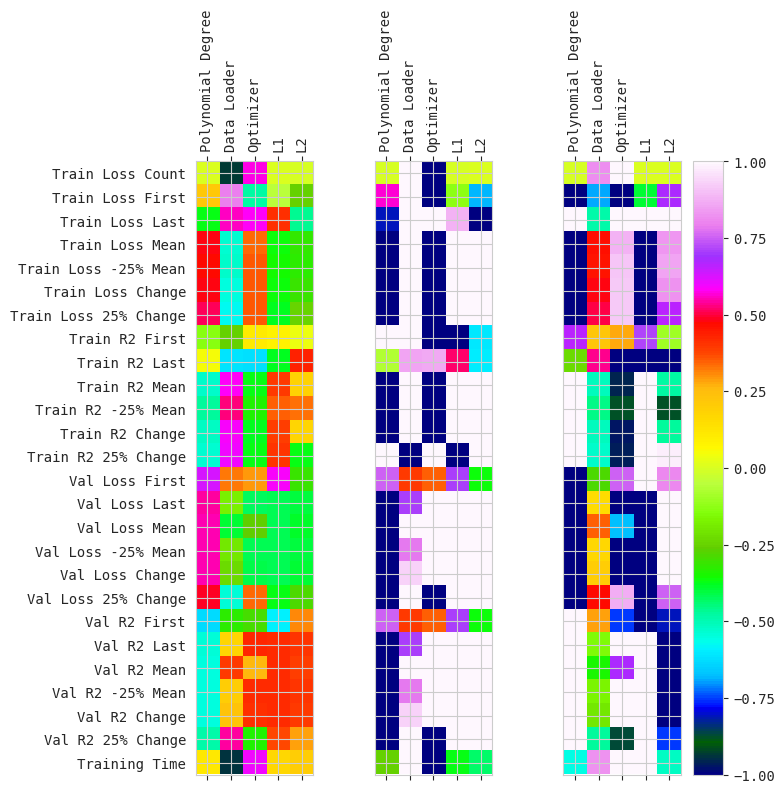

In [77]:
analysis_corr = ds_analysis_num.corr().loc[ds_analysis_num.columns[:26], ds_analysis_num.columns[26:]]

fig, axs = plt.subplots(1, 3, figsize=(8.2, 8))
axs: list[plt.Axes]

# plt.matshow(analysis_corr, cmap='gist_ncar', fignum=0, vmin=-1.0, vmax=1.0)
axs[0].matshow(np.sign(analysis_corr) * np.pow(np.abs(analysis_corr), 0.5),
               cmap='gist_ncar', vmin=-1.0, vmax=1.0)
axs[1].matshow(np.sign(analysis_corr) * np.pow(np.abs(analysis_corr), 0.5) /
               np.sum(analysis_corr.to_numpy(), axis=1, keepdims=True), cmap='gist_ncar', vmin=-1.0, vmax=1.0)
im = axs[2].matshow(np.sign(analysis_corr) * np.pow(np.abs(analysis_corr), 0.5) /
                    np.sum(analysis_corr.to_numpy(), axis=0, keepdims=True), cmap='gist_ncar', vmin=-1.0, vmax=1.0)
axs[0].set_yticks(range(26), ds_analysis_num.columns[:26])
axs[0].set_xticks(range(5), ds_analysis_num.columns[26:], rotation=90)
for i in range(1, 3):
    axs[i].set_yticks(range(26), ["" for _ in range(26)])
    axs[i].set_xticks(range(5), ds_analysis_num.columns[26:], rotation=90)
fig.colorbar(im, ax=axs[2])
plt.tight_layout()
plt.show()

In [78]:
analysis_corr

,Polynomial Degree,Data Loader,Optimizer,L1,L2
Train Loss Count,4.289372e-17,-0.871292,0.334215,2.428845e-17,-5.714930e-18
Train Loss First,4.460888e-02,0.623115,-0.230402,-2.249457e-03,-6.459751e-02
Train Loss Last,-1.392120e-01,0.310299,0.338793,1.664281e-01,-2.129369e-01
Train Loss Mean,2.338747e-01,-0.286047,0.114840,-1.294370e-01,-9.928592e-02
Train Loss -25% Mean,2.263518e-01,-0.277344,0.123620,-1.260505e-01,-1.047913e-01
Train Loss Change,2.306863e-01,-0.302215,0.126545,-1.291575e-01,-9.656915e-02
Train Loss 25% Change,2.589035e-01,-0.330429,0.126839,-1.438925e-01,-6.213738e-02
Train R2 First,-1.846439e-02,-0.064781,0.011698,7.277034e-03,1.459878e-03
Train R2 Last,2.278536e-03,-0.380232,-0.386993,-1.419849e-01,1.847792e-01
Train R2 Mean,-2.745649e-01,0.342289,-0.136275,1.526302e-01,3.263226e-02


# Analysis

So... I trained like 108 models, and that took 4 hours to complete.

Cool.

But now, how do we analyze all that data?

There are in fact, many many ways to visualize the results, but here I
will mainly use data decimation strategies.

Generally, ANOVA is a good way to start this analysis, but since there
are easy numerical representations available for most hyperparameters,
let's skip that part. Here are the numericalizations I performed iver
different our "features of study":

* Hidden Layers: It's already numerical, and yes, 2 hidden layers
  represent something more than 2 hidden layers.
* Activations: Since there are only two values, using `[-1, +1]`
  is a good way to represent the opposites.
* Data Loaders: Using 1 sample, 2048 samples or all samples ->
  since it's a growing trend, we can replace it with
  `[1, 2, 3]` respectively.
* Optimizations: Here also, we have only two values, hence using
  `[-1, +1]` to represent `Normal` and `Adam`.
* Regularization: In this case, I am not very sure if representing
  NoL, L1 and L2 as [0, 1, 2] is a good way or not. Therefore, I
  added two separate columns to represent whether L1/L2 were applied.

With the numerical representations ready, we can simply create a
correlation matrix to study the relations.

---

### 1) Data Loader - The most dominant factor

Clearly, Data Loader possesses the brightests of all colors. The choice of
a data loader heavily affects metrics like losses and accuracies.
Unfortunately, it's just a matter of how many iterations we could run
in the given time. Accordingly, the algorithm used for training the
models focussed on how fast the loss decreases. With a decent learning
rate of 0.0001, the training process could easily navigate through the
nearest minima without jumping away. Therefore, the choice of a higher
batch size of the training sample only provided less iterations to observe
the effect in its entirety. After all, how do we really present a fair
competition among different choices?

#### Key inference

No major inferences drawn. With the data available, we can say that using stochastic
gives poorer performances, however, with a limit on the number of iterations each
loader got, it's not presentable with just the correlations. In other plots it's inevitably evident.

### 2) L1 Regularization - The worst performance?

#### Key correlations

* Train Loss: moderate ve+
* Val Loss: moderate ve+
* Train Acc: small-moderate ve-
* Test Acc: moderate ve-

L1 is positively correlated with higher losses and negatively correlated with accuracy.
I recorded the loss before applying the regularization terms, and still there is such a
remarkable difference to be observed! However, this is expected. Any kind of
regularization forces the model to not learn well, which should cause loss to spike and
accuracy to sink. However, in that case, we should have observed a correlation with a
higher magnitude! Thanks to other hyperparameters, this applying a regularization can
actually help achieve better losses.

#### Key inference

L1 Regularization is rather too aggressive towards the model training.
Should use a lambda smaller than 1 in subsequent experiments.

### 3) L2 Regularization - Are you even there!

#### Key correlations

* Train Loss: weak ve+
* Val Loss: weak ve+

Much similar to L1 regularization, the effects of L2 shows the same directions in correlations
however with significantly lower magnitudes!

#### Key inference

Generally speaking, having a low correlation is rather not a very solid base for talking
relations; rather it's beter to say it does not make a difference! However, it will be a good
idea to experiment with a lambda higher than 1 in future experiments.

### 4) Hidden Layers - Interesting signals

#### Key correlations

* Training Time: moderate ve+
* Train Acc: small-moderate ve+
* Val Loss: small ve-
* Val Acc: small ve+

The strongest correlation in this category is Training Time, which is pretty well expected!
More layers, more numbers; more numbers, more math; more math, more computations;
more computations, more time!

#### Key inference

Adding up more layers show small benefits in training and validation metrics. This means that this
particular problem is pretty well solvable with a simple logistic regression with less efforts on
feature engineering. However, this indeed is an interesting observation! Losses are able
to reach lower records and accuracies see a higher cloud. More importantly, this happens in both the
cases of train-sets and validation-sets, which indicate the presence of a scope for further training
until validation accuracy starts dropping and test-set metrics fail.

Apparently, there is one more interesting observation, having more layers drops the initial accuracies.
Though this can not be taken as a conclusion until we perform the test on thousands of more models.
Could be a co incidence with the randomizer.

### 5) Activation Function - No effect at all

#### Key correlations

* Losses: small
* Accuracies: negligible
* Training Time: negligible

#### Key inference

Mathematical operations have already been so heavily optimized for computation across such activations
for ideal performances, that choosing an activation function does not matter anymore on such popular
frameworks like PyTorch. However, there is still a positive correlation with Training Time. This can not
be relied upon, since it really does depend on the implementation. Using lookup tables for sigmoid and
vector masking for relu seem like operations with similar costs.

In fact, running the same experiment with tensorflow, or plain numpy, or different hardware, can all result
in different correlations!

### 6) Activation Function - Start of the show

Key correlations:

* Training Time: small ve+
* 25% Change in Losses: small ve-
* 25% Change in Accuracies: small ve+

#### Key inference

The data suggests that using Adam over simple gradient descent increases the training time. But is that all?
Also note, that we are able to rise faster in accuracies and sink faster in losses when using Adam!
This mean that we achieve the goals faster as compared to normal gradient descent!

I should have focussed on causalty reports since the start and applied granger causality test - would have
been able to get much better insights. Maybe that's a good idea for future experiments!

### Other interesting patterns

##### Depth - Activation - Optimizer

Deeper models tend to have a slow start, but are able to achieve a better performance

##### Training Time vs Performance Metrics

Applying stochastic descent ain't a bad idea either - but that's very subjective to what the situation of
a dataset we are using has. But, within the results gathered from this dataset, stochastic descent gives
fast training times, but poorer performances when compared to batch descent. A good idea is to start off
with a good batch size in the middle, and keep incrementing it as loss reach closer to 0.

### Summary

Data Loader is the most influential hyperparameter. L1 regularization has strong effects and L2 regularization
has weaker effects on the metrics. Hidden Layers, Activation and Optimizer show mostly weak-to-small effects,
but draw out key inferences for further experiments.

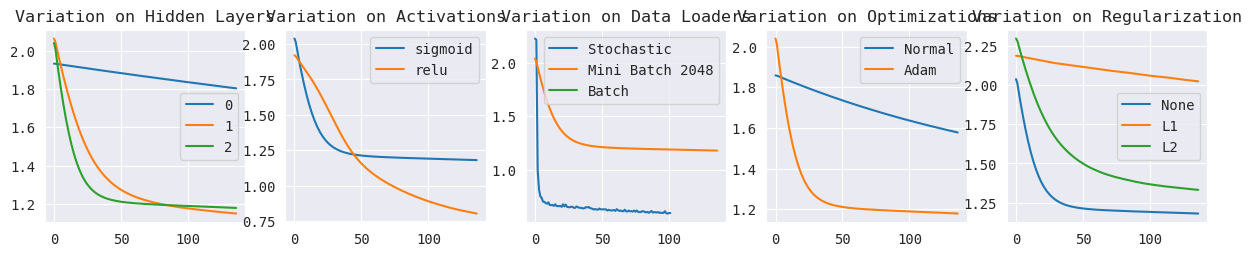

In [31]:
base_hyperparameter_selection = {
    'hidden_layers': [2],
    'activations': ['sigmoid'],
    'data_loaders': ['Mini Batch 2048'],
    'optimizations': ['Adam'],
    'regularization': [None],
}


def plot_hyperparameter_variation(title, name, values, ax):
    selection = base_hyperparameter_selection.copy()
    selection[name] = values
    ax.set_title("Variation on " + title)

    index = 0
    for hidden_layers, activations, data_loaders, optimizations, regularization \
            in itertools.product(selection['hidden_layers'], selection['activations'], selection['data_loaders'],
                                 selection['optimizations'], selection['regularization']):
        key = ", ".join([str(hidden_layers), activations, data_loaders, optimizations, str(regularization)])
        ax.plot(perm_history[key]["val_loss"], label=str(values[index]))
        index += 1

    ax.legend()


fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))
plot_hyperparameter_variation("Hidden Layers", "hidden_layers", perm_hidden_layers, axs[0])
plot_hyperparameter_variation("Activations", "activations", perm_activations, axs[1])
plot_hyperparameter_variation("Data Loaders", "data_loaders", perm_data_loaders, axs[2])
plot_hyperparameter_variation("Optimizations", "optimizations", perm_optimizations, axs[3])
plot_hyperparameter_variation("Regularization", "regularization", perm_regularization, axs[4])
plt.show()

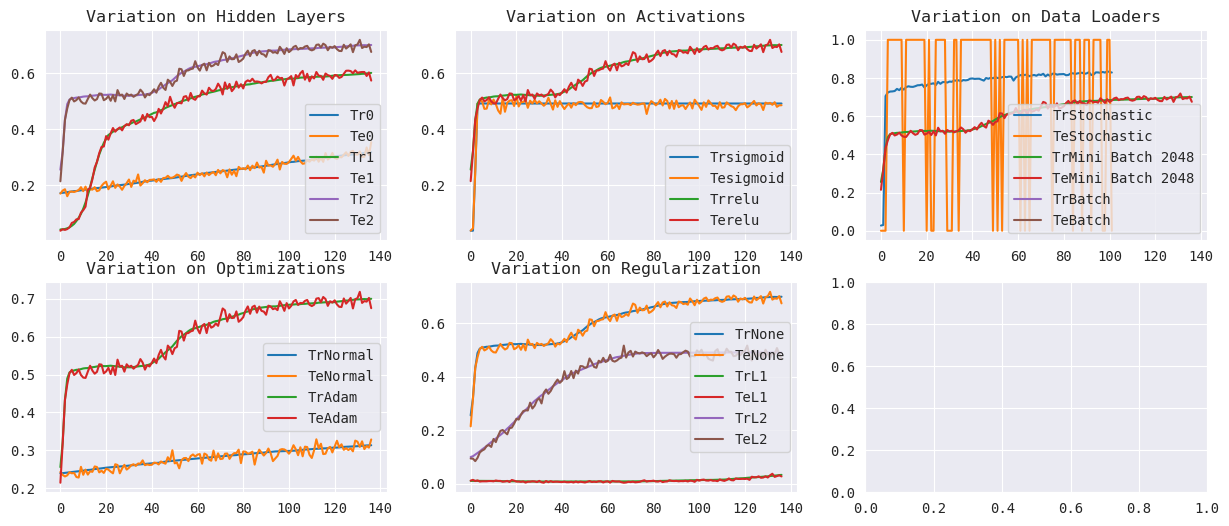

In [32]:
base_hyperparameter_selection = {
    'hidden_layers': [2],
    'activations': ['relu'],
    'data_loaders': ['Mini Batch 2048'],
    'optimizations': ['Adam'],
    'regularization': [None],
}


def plot_hyperparameter_variation(title, name, values, ax):
    selection = base_hyperparameter_selection.copy()
    selection[name] = values
    ax.set_title("Variation on " + title)

    index = 0
    for hidden_layers, activations, data_loaders, optimizations, regularization \
            in itertools.product(selection['hidden_layers'], selection['activations'], selection['data_loaders'],
                                 selection['optimizations'], selection['regularization']):
        key = ", ".join([str(hidden_layers), activations, data_loaders, optimizations, str(regularization)])

        m1 = perm_history[key]["val_acc"]
        m2 = perm_history[key]["train_acc"]
        if len(m1) > len(m2): m1, m2 = m2, m1
        ax.plot(m1, label="Tr" + str(values[index]))
        m2 = m2[::int(np.ceil(len(m2) / len(m1)))]
        ax.plot(m2, label="Te" + str(values[index]))

        index += 1

    ax.legend()
    # Length normalization not required...
    # min_data_size = min([len(d) for d in data])
    # data = [d[::len(d) // min_data_size] for d in data]


fig, axs = plt.subplots(2, 3, figsize=(15, 6))
axs = iter(np.reshape(axs, (-1)))
plot_hyperparameter_variation("Hidden Layers", "hidden_layers", perm_hidden_layers, next(axs))
plot_hyperparameter_variation("Activations", "activations", perm_activations, next(axs))
plot_hyperparameter_variation("Data Loaders", "data_loaders", perm_data_loaders, next(axs))
plot_hyperparameter_variation("Optimizations", "optimizations", perm_optimizations, next(axs))
plot_hyperparameter_variation("Regularization", "regularization", perm_regularization, next(axs))
plt.show()

# Part 6: Final Model Evaluation on the Test Set

In [80]:
loss_fn = nn.CrossEntropyLoss()

hidden_layers = 2
activation_fn = 'sigmoid'
training_strategy = 'Mini Batch 2048'
optimization_strategy = 'Adam'
regularization = 'L2'
learning_rate = 0.0033
device = 'cpu'
reg_lambda = 0.001

batch_size, optimizer, regularization, model = parse_elements(
    training_strategy, optimization_strategy, regularization, learning_rate, device)

train_loader, val_loader, test_loader = prepare_data(batch_size, 1, device)

train_loss, train_acc, val_loss, val_acc = [], [], [], []
total_time = 0

Epoch   0/10 [Train] Loss:  0.332797 Accuracy: 0.844755: 100%|██████████| 273/273 [00:28<00:00,  9.66it/s]
Epoch   1/10 [Train] Loss:  0.356802 Accuracy: 0.844755: 100%|██████████| 273/273 [00:26<00:00, 10.35it/s]
Epoch   2/10 [Train] Loss:  0.323513 Accuracy: 0.867133: 100%|██████████| 273/273 [00:24<00:00, 11.06it/s]
Epoch   3/10 [Train] Loss:  0.325391 Accuracy: 0.864336: 100%|██████████| 273/273 [00:25<00:00, 10.83it/s]
Epoch   4/10 [Train] Loss:  0.241417 Accuracy: 0.909091: 100%|██████████| 273/273 [00:24<00:00, 10.99it/s]
Epoch   5/10 [Train] Loss:  0.251078 Accuracy: 0.888112: 100%|██████████| 273/273 [00:25<00:00, 10.86it/s]
Epoch   6/10 [Train] Loss:  0.234554 Accuracy: 0.892308: 100%|██████████| 273/273 [00:24<00:00, 10.95it/s]
Epoch   7/10 [Train] Loss:  0.205570 Accuracy: 0.925874: 100%|██████████| 273/273 [00:24<00:00, 10.94it/s]
Epoch   8/10 [Train] Loss:  0.206068 Accuracy: 0.914685: 100%|██████████| 273/273 [00:24<00:00, 10.98it/s]
Epoch   9/10 [Train] Loss:  0.221835 

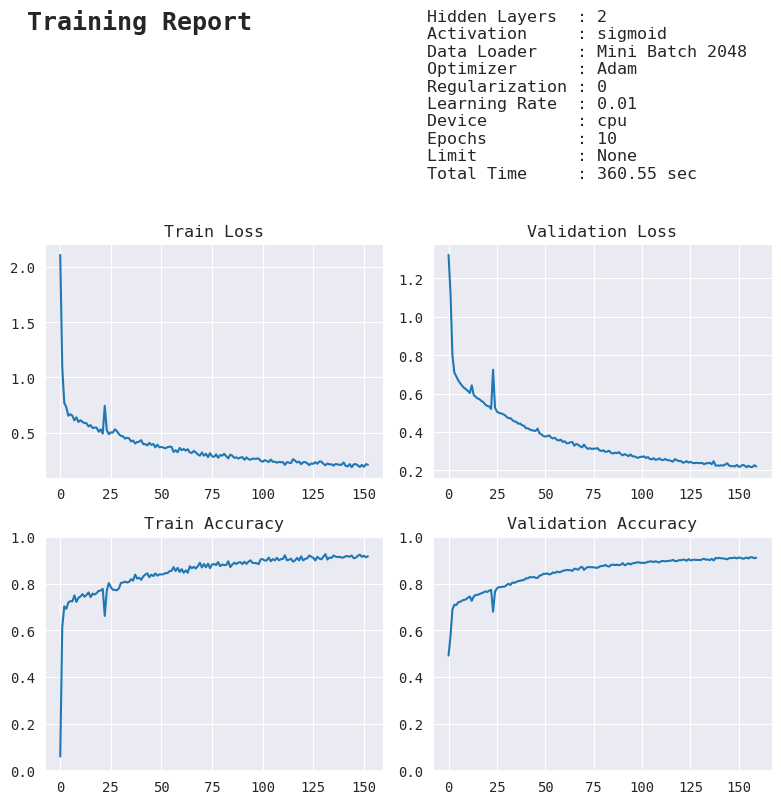

In [85]:
epochs = 10
limit = None
learning_rate = 0.01

for epoch in range(epochs):
    history = train_step(epoch, epochs, model, train_loader, val_loader, loss_fn,
                         optimizer, regularization, limit, reg_lambda, learning_rate)
    train_loss.extend(history['train_loss'])
    train_acc.extend(history['train_acc'])
    val_loss.extend(history['val_loss'])
    val_acc.extend(history['val_acc'])
    total_time += history['total_time']

history = {
    'parameters': {'Hidden Layers': hidden_layers, 'Activation': activation_fn,
                   'Data Loader': training_strategy, 'Optimizer': optimization_strategy,
                   'Regularization': regularization, 'Learning Rate': learning_rate, 'Device': device,
                   'Epochs': epochs, 'Limit': limit},
    'model': model,
    'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc,
    'total_time': total_time
}

prepare_report(history)
chime.info()

In [88]:
with torch.no_grad():
    model.eval()
    p_test = model(torch.asarray(x_test, dtype=torch.float32, device=device)).numpy()

In [89]:
save_history("bounded_final", history)

# Part 7: Conclusion

In [ ]:
# TODO
#  use set seed in conduct experiment function
#  why validation results not being printed
#  add an option to disable val printing, or val recording over all
#  save the freaking model (the whole history object to disk)